<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>MCMC </font></h3>
    
    MCMCの計算を行うコードを実行しています。



In [5]:
import matplotlib.pyplot as plt
import numpy as np

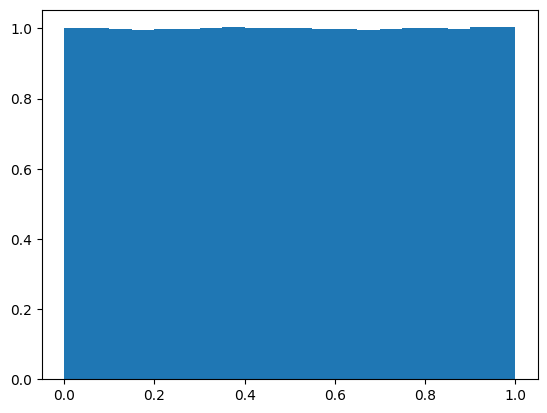

In [6]:
def lcg(a, b, m, n, x0):
    x = np.zeros(n)
    u = np.zeros(n)
    x[0] = x0
    u[0] = x0 / m
    for k in range(1, n):
        x[k] = (a * x[k - 1] + b) % m
        u[k] = x[k] / m
    return u 

n = 100000
a = 106
b = 1283
m = 6075
x0 = 1
u = lcg(a, b, m, n, x0);
plt.hist(u, bins=20, density=True);

Text(0.5, 1.0, '$u_{k+1}$ vs $u_k$')

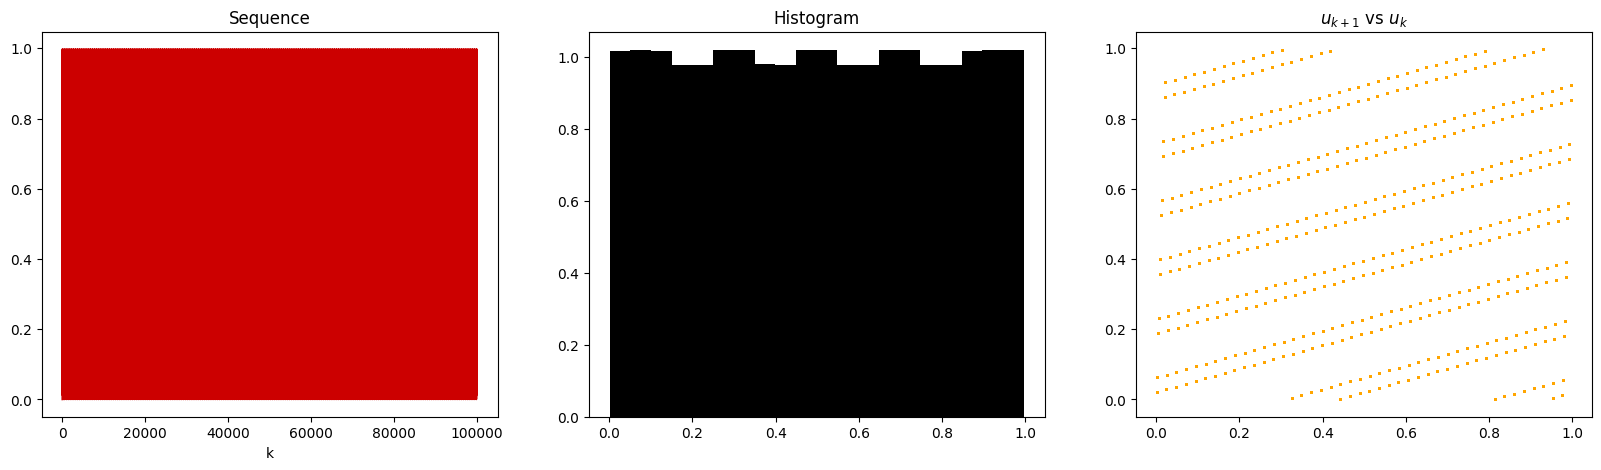

In [7]:
m = 2048
a = 43
b = 0
x0 = 1

u = lcg(a, b, m, n, x0)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(u, color=[0.8, 0, 0])
axs[0].set_title("Sequence")
axs[0].set_xlabel("k")
axs[1].hist(u, bins=20, density=True, color='k', alpha=1)
axs[1].set_title("Histogram")
axs[2].scatter(u[:-1], u[1:], c='orange', s=0.1)
axs[2].set_title("$u_{k+1}$ vs $u_k$")

Text(0, 0.5, '$z_2$')

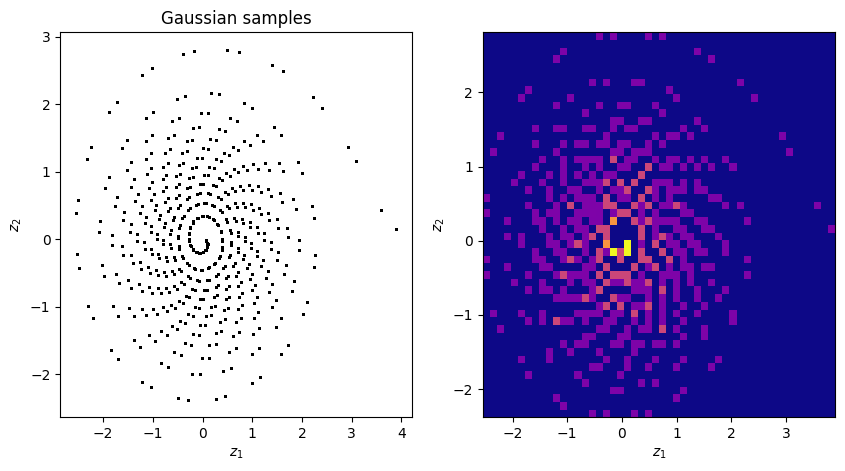

In [8]:
def box_muller(u1, u2):
    z1 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z2 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return z1, z2

n = 100000
m = 2048
a = 43
b = 0
x0 = 1

u1 = lcg(a, b, m, n, x0)
u2 = lcg(a, b, m, n, x0 + 12)
z1, z2 = box_muller(u1, u2)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(z1, z2, s=0.1, c='k')
axs[0].set_title("Gaussian samples")
axs[0].set_xlabel("$z_1$")
axs[0].set_ylabel("$z_2$")
axs[1].hist2d(z1, z2, bins=50, cmap='plasma')
axs[1].set_xlabel("$z_1$")
axs[1].set_ylabel("$z_2$")

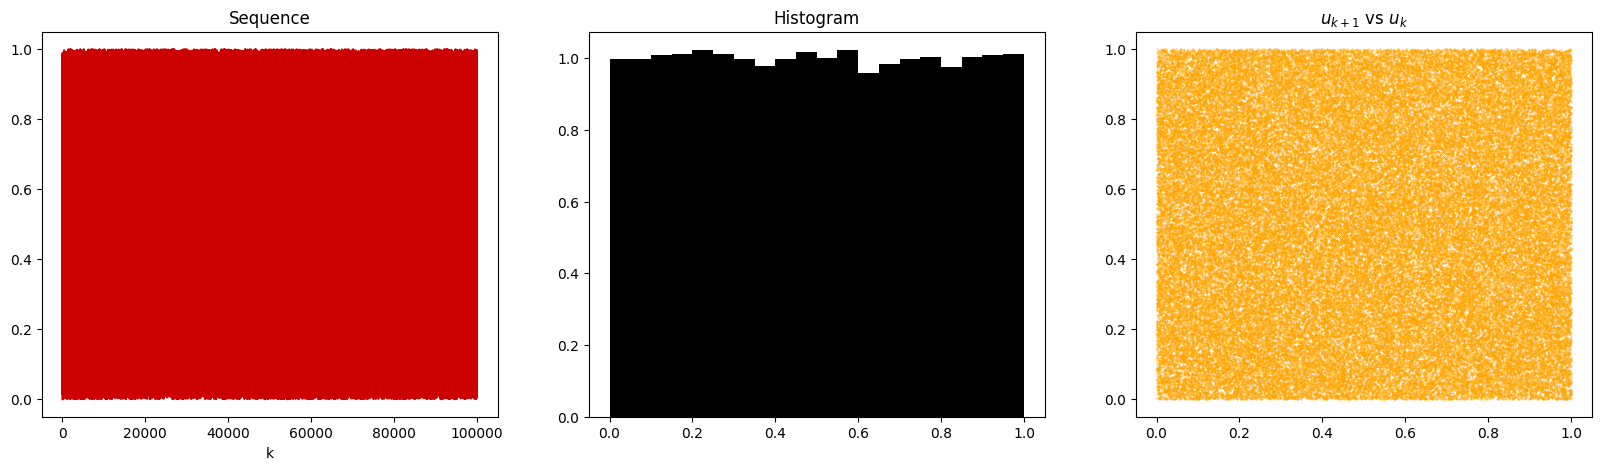

In [10]:
m = 2**32
a = 1664525
x0 = 15
b = 1013904223

u = lcg(a, b, m, n, x0)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(u, color=[0.8, 0, 0])
axs[0].set_title("Sequence")
axs[0].set_xlabel("k")
axs[1].hist(u, bins=20, density=True, color='k', alpha=1)
axs[1].set_title("Histogram")
axs[2].scatter(u[:-1], u[1:], c='orange', s=0.1)
axs[2].set_title("$u_{k+1}$ vs $u_k$")
plt.show()